In [3]:
import pandas as pd
from dotenv import load_dotenv
import os
import numpy as np
from scipy.optimize import curve_fit

from sqlalchemy import create_engine
from sqlalchemy import text

from matplotlib import pyplot as plt
load_dotenv()

user = os.environ.get("DB_USERNAME")
password = os.environ.get("DB_PASSWORD")
hostname = os.environ.get("DB_HOST")
database_name =  os.environ.get("DB_NAME")
port = os.environ.get("DB_PORT")
cluster = os.environ.get("DB_CLUSTER")
youtube_api_key = os.environ.get("YOUTUBE_API_KEY")

engine = create_engine(f'cockroachdb://{user}:{password}@{hostname}:{port}/{database_name}?sslmode=require&options=--cluster={cluster}')

In [4]:
conn = engine.connect()
df = pd.read_sql("""SELECT vvl.* FROM video_view_lifecycle vvl
                    JOIN video_notification_feed vnf ON vvl.video_id = vnf.video_id
                    where vnf.record_timestamp > '2022-06-27 00:00:00.00' 
                    and vnf.channel_id in ('UCXIJgqnII2ZOINSWNOGFThA')
                    ORDER BY vvl.video_id desc, vvl.record_timestamp asc""", 
                conn)

In [5]:
def calc_timedetlas(row):
    return pd.Timedelta(row["record_timestamp"] - df[df["video_id"] == row["video_id"]].iloc[0]["date_uploaded"], unit='seconds').total_seconds() / 60

def calc_percentage_deltas(row):
    return row["views"] / df[df["video_id"] == row["video_id"]].iloc[0]["views"] - 1

df["time_delta"] = df.apply(calc_timedetlas, axis=1)
df["view_delta"] = df.groupby(['video_id'])['views'].diff().fillna(0)
df["view_percentage_delta"] = df.apply(calc_percentage_deltas, axis=1)
df = df.drop_duplicates(subset=['time_delta'])

/var/folders/0z/7vw3n45915b9fwdtfny4prlh0000gn/T/ipykernel_13734/1367104449.py:5: RuntimeWarning: invalid value encountered in long_scalars
  return row["views"] / df[df["video_id"] == row["video_id"]].iloc[0]["views"] - 1
/var/folders/0z/7vw3n45915b9fwdtfny4prlh0000gn/T/ipykernel_13734/1367104449.py:5: RuntimeWarning: divide by zero encountered in long_scalars
  return row["views"] / df[df["video_id"] == row["video_id"]].iloc[0]["views"] - 1


In [9]:
df = df[["video_id", "time_delta", "views"]]
df.head()
video_dfs = [video_id for _, video_id in df.groupby('video_id')]
video_dfs = [video_df[:] for video_df in video_dfs if video_df.shape[0] >= 50]
video_dfs = video_dfs[:20]
len(video_dfs)


20

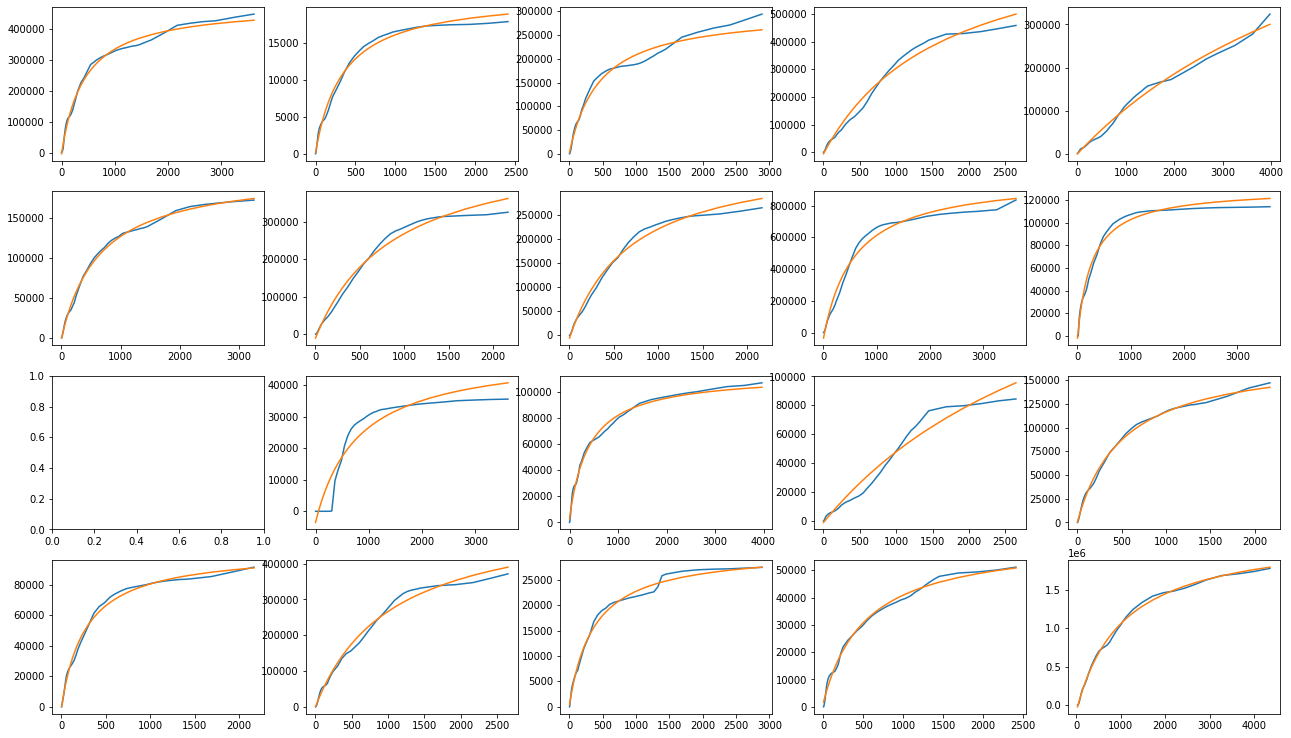

In [11]:
def eq(x, a, b, c, d):
    return (a + (c * x))/(b + (d * x))

fig, axs = plt.subplots(4, 5, figsize=(22,13))

training_info = []
for video_df, ax in zip(video_dfs, axs.reshape(-1)):
    x_data = video_df.time_delta
    y_data = video_df.views

    param, param_cov = None, None
    try:
        param, param_cov = curve_fit(eq, x_data, y_data)
    except RuntimeError as e:
        continue
    y_pred = eq(video_df.time_delta, *param)
    

    # ax.set_xlim([0, 12000])

    tuples = list(zip(video_df.time_delta, video_df.views))
    labels = param

    training_info.append({"points": tuples, "params": param})

    ax.plot(video_df.time_delta, video_df.views)
    ax.plot(video_df.time_delta, y_pred)



In [76]:
X_train = [_["points"][:10] for _ in training_info[:12]]
y_train = [_["params"] for _ in training_info[:12]]

X_test = [_["points"][:10] for _ in training_info[12:]]
y_test = [_["params"] for _ in training_info[12:]]

In [80]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score

model = MLPRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

for eq_true, eq_pred  in zip(y_test, y_pred):
    sub = np.subtract(eq_true, eq_pred)
    print(sum(sub))


ValueError: Found array with dim 3. Estimator expected <= 2.